In [1]:
import sys
import os
import random
import gc
import time
import torch
import numpy as np
import pandas as pd
import ast
from tqdm import tqdm
from scipy.stats import spearmanr, pearsonr, kendalltau, rankdata
from sklearn.metrics import ndcg_score
from transformers import AutoModelForCausalLM, AutoTokenizer
from accelerate import Accelerator
os.environ["CUDA_VISIBLE_DEVICES"] = "3" 
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)
from SHapRAG.rag_shap import *
from SHapRAG.utils import *

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# df= pd.read_csv("../data/synthetic_data/20_synergy_hard_negatives.csv",index_col=False, sep=";")
df= pd.read_csv("../data/complementary.csv")

In [3]:
SEED = 42
# Initialize Accelerator
accelerator_main = Accelerator(mixed_precision="fp16")

# Load Model
if accelerator_main.is_main_process:
    print("Main Script: Loading model...")
# model_path = "mistralai/Mistral-7B-Instruct-v0.3"
model_path = "meta-llama/Llama-3.1-8B-Instruct"
# model_path = "Qwen/Qwen2.5-3B-Instruct"

model_cpu = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.float16
)
tokenizer = AutoTokenizer.from_pretrained(model_path)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model_cpu.config.pad_token_id = tokenizer.pad_token_id
    if hasattr(model_cpu, 'generation_config') and model_cpu.generation_config is not None:
        model_cpu.generation_config.pad_token_id = tokenizer.pad_token_id

if accelerator_main.is_main_process:
    print("Main Script: Preparing model with Accelerator...")
prepared_model = accelerator_main.prepare(model_cpu)
unwrapped_prepared_model = accelerator_main.unwrap_model(prepared_model)
unwrapped_prepared_model.eval()
if accelerator_main.is_main_process:
    print("Main Script: Model prepared and set to eval.")

# Define utility cache

accelerator_main.wait_for_everyone()

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Main Script: Loading model...


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


Main Script: Preparing model with Accelerator...
Main Script: Model prepared and set to eval.


In [5]:
num_questions_to_run=len(df.question)
# num_questions_to_run=1
k_values = [1,2,3,4,5]
all_results=[]
extras=[]
# Define ground truth set of docs for precision (adapt as needed)
# e.g., if first 2 docs are always relevant
def get_gtset_k():
    return [0, 1]
correctness=[]
llm_response=[]
for i in tqdm(range(num_questions_to_run), disable=not accelerator_main.is_main_process):
    query = df.question[i]
    if accelerator_main.is_main_process:
        print(f"\n--- Question {i+1}/{num_questions_to_run}: {query[:60]}... ---")

    p = ast.literal_eval(df.context[i])
    docs = p[:5] + [p[1]] + p[5:]
    utility_cache_base_dir = f"../Experiment_data/synthetic/{model_path.split('/')[1]}/complementatiry"
    utility_cache_filename = f"utilities_q_idx{i}.pkl"
    current_utility_path = os.path.join(utility_cache_base_dir, utility_cache_filename)

    if accelerator_main.is_main_process:
        os.makedirs(os.path.dirname(current_utility_path), exist_ok=True)

    harness = ContextAttribution(
        items=docs,
        query=query,
        prepared_model=prepared_model,
        prepared_tokenizer=tokenizer,
        accelerator=accelerator_main,
        utility_cache_path=current_utility_path
    )
    res = evaluate(df.question[i], harness.target_response, df.answer[i])
    if res=="True":
        if accelerator_main.is_main_process:
            methods_results = {}
            metrics_results = {}
            extra_results = {}

            m_samples_map = { "L":256}

            # Store FM models for later R²/MSE
            fm_models = {}

            for size_key, actual_samples in m_samples_map.items():

                methods_results[f"ContextCite_{actual_samples}"], fm_models[f"ContextCite_{actual_samples}"] = harness.compute_contextcite(
                    num_samples=actual_samples, seed=SEED
                )
                # FM Weights (loop over ranks 0–5)
                for rank in range(5, -1, -1):
                    methods_results[f"FM_WeightsLU_{rank}_{actual_samples}"], extra_results[f"Flu_{rank}_{actual_samples}"], fm_models[f"FM_WeightsLU_{rank}_{actual_samples}"] = harness.compute_wss(
                        num_samples=actual_samples,
                        seed=SEED,
                        sampling="uniform",
                        sur_type="fm",
                        rank=rank
                    )

                try:
                    attributions, interactions = harness.compute_spex(sample_budget=actual_samples, max_order=2)
                    methods_results[f"FBII_{actual_samples}"] = attributions['fbii']
                    methods_results[f"Spex_{actual_samples}"] = attributions['fourier']
                    methods_results[f"FSII_{actual_samples}"] = attributions['fsii']

                    extra_results.update({
                    f"Int_FSII_{actual_samples}":interactions['fsii'],
                    f"Int_FBII_{actual_samples}":interactions['fbii'],
                    f"Int_Spex_{actual_samples}":interactions['fourier']
                                                                            })
                except Exception: pass


            methods_results["LOO"] = harness.compute_loo()
            methods_results["ARC-JSD"] = harness.compute_arc_jsd()

            # --- Evaluation Metrics ---
            metrics_results["topk_probability"] = harness.evaluate_topk_performance(
                methods_results, fm_models, k_values
            )

            # R²
            metrics_results["R2"] = harness.r2(methods_results,30,mode='logit-prob', models=fm_models)


            # LDS per method
            # metrics_results["LDS"] = harness.lds(methods_results,30,mode='raw-prob', models=fm_models)



            all_results.append({
                "query_index": i,
                "query": query,
                "ground_truth": df.answer[i],
                "response": harness.target_response,
                "methods": methods_results,
                "metrics": metrics_results
            })
            extras.append(extra_results)

            # Save utility cache
            harness.save_utility_cache(current_utility_path)

  0%|          | 0/10 [00:00<?, ?it/s]


--- Question 1/10: What are the two primary materials used to construct a Xylot... ---
Main Process: Attempting to load utility cache from ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/complementatiry/utilities_q_idx0.pkl...
Successfully loaded 294 cached utility entries.



































































































































Computing utilities for ContextCite: 100%|██████████| 256/256 [00:22<00:00, 11.33it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 493447.53it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 363118.64it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 519971.83it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 606291.26it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 646443.00it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 658737.32it/s]










LOO Calls (logit-prob): 100%|██████████| 11/11 [00:01<00:00,  8.61it/s]


  (Divergence Utility) Caching baseline token distributions for full context...














LOO Calls (divergence_utility): 100%|██████████| 11/11 [00:01<00:00,  7.64it/s]

Exhaustive Top-1 Search: 100%|██████████| 10/10 [00:00<00:00, 2812.52it/s]

Exhaustive Top-2 Search: 100%|██████████| 45/45 [00:00<00:00, 2919.79it/s]

Exhaustive Top-3 Search: 100%|██████████| 120/120 [00:00<00:00, 3039.17it/s]

Exhaustive Top-4 Search: 100%|██████████| 210/210 [00:00<00:00, 2726.08it/s]

Exhaustive Top-5 Search: 100%|██████████| 252/252 [00:00<00:00, 2749.50it/s]

Exhaustive Top-1 Search: 100%|██████████| 10/10 [00:00<00:00, 2128.22it/s]

Exhaustive Top-2 Search: 100%|██████████| 45/45 [00:00<00:00, 2379.67it/s]

Exhaustive Top-3 Search: 100%|██████████| 120/120 [00:00<00:00, 2736.43it/s]

Exhaustive Top-4 Search: 100%|██████████| 210/210 [00:00<00:00, 2761.70it/s]

Exhaustive Top-5 Search: 100%|██████████| 252/252 [00:00<00:00, 2716.90it/s]

Exhaustive Top-1 Search: 100%|██████████| 10/10 [00:00<00:00, 2555.79it/s]

Exhaustive Top-2 Search: 100%|██████████| 45/45 [00:00<00:0

Main Process: Saving 599 utility entries to ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/complementatiry/utilities_q_idx0.pkl...
Save complete.

--- Question 2/10: What two distinct abilities does a Xylotian 'Chrono-Weaver' ... ---
Main Process: Attempting to load utility cache from ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/complementatiry/utilities_q_idx1.pkl...
Successfully loaded 296 cached utility entries.



































































































































Computing utilities for ContextCite: 100%|██████████| 256/256 [00:22<00:00, 11.39it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 481714.59it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 561874.32it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 611122.27it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 608352.31it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 515478.55it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 505290.27it/s]










LOO Calls (logit-prob): 100%|██████████| 11/11 [00:01<00:00,  8.73it/s]


  (Divergence Utility) Caching baseline token distributions for full context...














LOO Calls (divergence_utility): 100%|██████████| 11/11 [00:01<00:00,  7.82it/s]

Exhaustive Top-1 Search: 100%|██████████| 10/10 [00:00<00:00, 2718.98it/s]

Exhaustive Top-2 Search: 100%|██████████| 45/45 [00:00<00:00, 2768.84it/s]

Exhaustive Top-3 Search: 100%|██████████| 120/120 [00:00<00:00, 3119.76it/s]

Exhaustive Top-4 Search: 100%|██████████| 210/210 [00:00<00:00, 3075.13it/s]

Exhaustive Top-5 Search: 100%|██████████| 252/252 [00:00<00:00, 3136.30it/s]

Exhaustive Top-1 Search: 100%|██████████| 10/10 [00:00<00:00, 2805.74it/s]

Exhaustive Top-2 Search: 100%|██████████| 45/45 [00:00<00:00, 2385.05it/s]

Exhaustive Top-3 Search: 100%|██████████| 120/120 [00:00<00:00, 2926.38it/s]

Exhaustive Top-4 Search: 100%|██████████| 210/210 [00:00<00:00, 3143.46it/s]

Exhaustive Top-5 Search: 100%|██████████| 252/252 [00:00<00:00, 3085.87it/s]

Exhaustive Top-1 Search: 100%|██████████| 10/10 [00:00<00:00, 2914.33it/s]

Exhaustive Top-2 Search: 100%|██████████| 45/45 [00:00<00:0

Main Process: Saving 603 utility entries to ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/complementatiry/utilities_q_idx1.pkl...
Save complete.

--- Question 3/10: What are the two key functions of 'Symbiotic Spores' in Xylo... ---
Main Process: Attempting to load utility cache from ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/complementatiry/utilities_q_idx2.pkl...
Successfully loaded 297 cached utility entries.



































































































































Computing utilities for ContextCite: 100%|██████████| 256/256 [00:23<00:00, 10.83it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 434010.44it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 471559.87it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 556631.32it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 621378.37it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 634974.47it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 632729.42it/s]










LOO Calls (logit-prob): 100%|██████████| 11/11 [00:01<00:00,  8.68it/s]


  (Divergence Utility) Caching baseline token distributions for full context...














LOO Calls (divergence_utility): 100%|██████████| 11/11 [00:01<00:00,  7.60it/s]

Exhaustive Top-1 Search: 100%|██████████| 10/10 [00:00<00:00, 2719.69it/s]

Exhaustive Top-2 Search: 100%|██████████| 45/45 [00:00<00:00, 2913.43it/s]

Exhaustive Top-3 Search: 100%|██████████| 120/120 [00:00<00:00, 3128.83it/s]

Exhaustive Top-4 Search: 100%|██████████| 210/210 [00:00<00:00, 3014.08it/s]

Exhaustive Top-5 Search: 100%|██████████| 252/252 [00:00<00:00, 3109.06it/s]

Exhaustive Top-1 Search: 100%|██████████| 10/10 [00:00<00:00, 2947.72it/s]

Exhaustive Top-2 Search: 100%|██████████| 45/45 [00:00<00:00, 2788.19it/s]

Exhaustive Top-3 Search: 100%|██████████| 120/120 [00:00<00:00, 3141.08it/s]

Exhaustive Top-4 Search: 100%|██████████| 210/210 [00:00<00:00, 3094.79it/s]

Exhaustive Top-5 Search: 100%|██████████| 252/252 [00:00<00:00, 3132.51it/s]

Exhaustive Top-1 Search: 100%|██████████| 10/10 [00:00<00:00, 2724.46it/s]

Exhaustive Top-2 Search: 100%|██████████| 45/45 [00:00<00:0

Main Process: Saving 602 utility entries to ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/complementatiry/utilities_q_idx2.pkl...
Save complete.

--- Question 4/10: What two types of energy are harvested by the 'Dual-Resonanc... ---



































































































































Computing utilities for ContextCite: 100%|██████████| 256/256 [00:21<00:00, 12.14it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 474267.59it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 584508.34it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 626088.53it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 647612.68it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 639512.70it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 643730.11it/s]










LOO Calls (logit-prob): 100%|██████████| 11/11 [00:01<00:00,  8.46it/s]


  (Divergence Utility) Caching baseline token distributions for full context...














LOO Calls (divergence_utility): 100%|██████████| 11/11 [00:01<00:00,  7.61it/s]

Exhaustive Top-1 Search: 100%|██████████| 10/10 [00:00<00:00, 2689.17it/s]

Exhaustive Top-2 Search: 100%|██████████| 45/45 [00:00<00:00, 2518.73it/s]

Exhaustive Top-3 Search: 100%|██████████| 120/120 [00:00<00:00, 3109.14it/s]

Exhaustive Top-4 Search: 100%|██████████| 210/210 [00:00<00:00, 3070.67it/s]

Exhaustive Top-5 Search: 100%|██████████| 252/252 [00:00<00:00, 3136.50it/s]

Exhaustive Top-1 Search: 100%|██████████| 10/10 [00:00<00:00, 2270.75it/s]

Exhaustive Top-2 Search: 100%|██████████| 45/45 [00:00<00:00, 2574.67it/s]

Exhaustive Top-3 Search: 100%|██████████| 120/120 [00:00<00:00, 3119.45it/s]

Exhaustive Top-4 Search: 100%|██████████| 210/210 [00:00<00:00, 3075.61it/s]

Exhaustive Top-5 Search: 100%|██████████| 252/252 [00:00<00:00, 3120.55it/s]

Exhaustive Top-1 Search: 100%|██████████| 10/10 [00:00<00:00, 2971.31it/s]

Exhaustive Top-2 Search: 100%|██████████| 45/45 [00:00<00:0

Main Process: Saving 306 utility entries to ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/complementatiry/utilities_q_idx3.pkl...
Save complete.

--- Question 5/10: What are the two main defensive mechanisms of a Xylotian 'Gu... ---




































































































































Computing utilities for ContextCite: 100%|██████████| 256/256 [00:24<00:00, 10.50it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 479349.03it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 583238.36it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 618514.88it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 631612.84it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 636480.04it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 622459.03it/s]










LOO Calls (logit-prob): 100%|██████████| 11/11 [00:01<00:00,  8.50it/s]


  (Divergence Utility) Caching baseline token distributions for full context...














LOO Calls (divergence_utility): 100%|██████████| 11/11 [00:01<00:00,  7.30it/s]

Exhaustive Top-1 Search: 100%|██████████| 10/10 [00:00<00:00, 2710.02it/s]

Exhaustive Top-2 Search: 100%|██████████| 45/45 [00:00<00:00, 2701.78it/s]

Exhaustive Top-3 Search: 100%|██████████| 120/120 [00:00<00:00, 3116.57it/s]

Exhaustive Top-4 Search: 100%|██████████| 210/210 [00:00<00:00, 3100.57it/s]

Exhaustive Top-5 Search: 100%|██████████| 252/252 [00:00<00:00, 3139.06it/s]

Exhaustive Top-1 Search: 100%|██████████| 10/10 [00:00<00:00, 2273.83it/s]

Exhaustive Top-2 Search: 100%|██████████| 45/45 [00:00<00:00, 2981.21it/s]

Exhaustive Top-3 Search: 100%|██████████| 120/120 [00:00<00:00, 3142.06it/s]

Exhaustive Top-4 Search: 100%|██████████| 210/210 [00:00<00:00, 3066.20it/s]

Exhaustive Top-5 Search: 100%|██████████| 252/252 [00:00<00:00, 3154.74it/s]

Exhaustive Top-1 Search: 100%|██████████| 10/10 [00:00<00:00, 2189.78it/s]

Exhaustive Top-2 Search: 100%|██████████| 45/45 [00:00<00:0

Main Process: Saving 306 utility entries to ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/complementatiry/utilities_q_idx4.pkl...
Save complete.

--- Question 6/10: What are the two primary components used in the creation of ... ---



































































































































Computing utilities for ContextCite: 100%|██████████| 256/256 [00:23<00:00, 11.03it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 517715.44it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 576041.75it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 592899.96it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 463819.36it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 503395.14it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 583872.66it/s]










LOO Calls (logit-prob): 100%|██████████| 11/11 [00:01<00:00,  8.81it/s]


  (Divergence Utility) Caching baseline token distributions for full context...














LOO Calls (divergence_utility): 100%|██████████| 11/11 [00:01<00:00,  7.85it/s]

Exhaustive Top-1 Search: 100%|██████████| 10/10 [00:00<00:00, 2696.09it/s]

Exhaustive Top-2 Search: 100%|██████████| 45/45 [00:00<00:00, 2774.58it/s]

Exhaustive Top-3 Search: 100%|██████████| 120/120 [00:00<00:00, 3144.55it/s]

Exhaustive Top-4 Search: 100%|██████████| 210/210 [00:00<00:00, 3149.28it/s]

Exhaustive Top-5 Search: 100%|██████████| 252/252 [00:00<00:00, 3079.68it/s]

Exhaustive Top-1 Search: 100%|██████████| 10/10 [00:00<00:00, 2862.42it/s]

Exhaustive Top-2 Search: 100%|██████████| 45/45 [00:00<00:00, 2574.63it/s]

Exhaustive Top-3 Search: 100%|██████████| 120/120 [00:00<00:00, 3154.82it/s]

Exhaustive Top-4 Search: 100%|██████████| 210/210 [00:00<00:00, 3084.70it/s]

Exhaustive Top-5 Search: 100%|██████████| 252/252 [00:00<00:00, 3104.56it/s]

Exhaustive Top-1 Search: 100%|██████████| 10/10 [00:00<00:00, 3014.23it/s]

Exhaustive Top-2 Search: 100%|██████████| 45/45 [00:00<00:0

Main Process: Saving 306 utility entries to ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/complementatiry/utilities_q_idx5.pkl...
Save complete.

--- Question 7/10: What two sensory inputs does the 'Pathfinder Helm' integrate... ---



































































































































Computing utilities for ContextCite: 100%|██████████| 256/256 [00:20<00:00, 12.44it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 496183.84it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 576660.49it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 623543.45it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 633476.00it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 635350.19it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 641422.83it/s]










LOO Calls (logit-prob): 100%|██████████| 11/11 [00:01<00:00,  8.67it/s]


  (Divergence Utility) Caching baseline token distributions for full context...














LOO Calls (divergence_utility): 100%|██████████| 11/11 [00:01<00:00,  7.59it/s]

Exhaustive Top-1 Search: 100%|██████████| 10/10 [00:00<00:00, 2701.65it/s]

Exhaustive Top-2 Search: 100%|██████████| 45/45 [00:00<00:00, 2627.42it/s]

Exhaustive Top-3 Search: 100%|██████████| 120/120 [00:00<00:00, 3107.89it/s]

Exhaustive Top-4 Search: 100%|██████████| 210/210 [00:00<00:00, 3121.88it/s]

Exhaustive Top-5 Search: 100%|██████████| 252/252 [00:00<00:00, 3158.49it/s]

Exhaustive Top-1 Search: 100%|██████████| 10/10 [00:00<00:00, 2319.99it/s]

Exhaustive Top-2 Search: 100%|██████████| 45/45 [00:00<00:00, 2961.20it/s]

Exhaustive Top-3 Search: 100%|██████████| 120/120 [00:00<00:00, 3123.61it/s]

Exhaustive Top-4 Search: 100%|██████████| 210/210 [00:00<00:00, 3137.91it/s]

Exhaustive Top-5 Search: 100%|██████████| 252/252 [00:00<00:00, 3143.07it/s]

Exhaustive Top-1 Search: 100%|██████████| 10/10 [00:00<00:00, 2830.16it/s]

Exhaustive Top-2 Search: 100%|██████████| 45/45 [00:00<00:0

Main Process: Saving 310 utility entries to ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/complementatiry/utilities_q_idx6.pkl...
Save complete.

--- Question 8/10: What two distinct phases define the operation of a Xylotian ... ---



































































































































Computing utilities for ContextCite: 100%|██████████| 256/256 [00:21<00:00, 12.17it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 508159.88it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 583555.34it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 627185.64it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 624995.24it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 639893.82it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 644116.27it/s]










LOO Calls (logit-prob): 100%|██████████| 11/11 [00:01<00:00,  8.57it/s]


  (Divergence Utility) Caching baseline token distributions for full context...














LOO Calls (divergence_utility): 100%|██████████| 11/11 [00:01<00:00,  7.51it/s]

Exhaustive Top-1 Search: 100%|██████████| 10/10 [00:00<00:00, 2732.27it/s]

Exhaustive Top-2 Search: 100%|██████████| 45/45 [00:00<00:00, 2776.95it/s]

Exhaustive Top-3 Search: 100%|██████████| 120/120 [00:00<00:00, 3146.93it/s]

Exhaustive Top-4 Search: 100%|██████████| 210/210 [00:00<00:00, 3118.83it/s]

Exhaustive Top-5 Search: 100%|██████████| 252/252 [00:00<00:00, 2997.31it/s]

Exhaustive Top-1 Search: 100%|██████████| 10/10 [00:00<00:00, 2263.28it/s]

Exhaustive Top-2 Search: 100%|██████████| 45/45 [00:00<00:00, 2496.54it/s]

Exhaustive Top-3 Search: 100%|██████████| 120/120 [00:00<00:00, 3095.24it/s]

Exhaustive Top-4 Search: 100%|██████████| 210/210 [00:00<00:00, 2168.32it/s]

Exhaustive Top-5 Search: 100%|██████████| 252/252 [00:00<00:00, 2766.05it/s]

Exhaustive Top-1 Search: 100%|██████████| 10/10 [00:00<00:00, 2216.86it/s]

Exhaustive Top-2 Search: 100%|██████████| 45/45 [00:00<00:0

Main Process: Saving 311 utility entries to ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/complementatiry/utilities_q_idx7.pkl...
Save complete.

--- Question 9/10: What are the two main functions of the 'Aura-Cloak' worn by ... ---





















































































































































Computing utilities for ContextCite: 100%|██████████| 256/256 [00:26<00:00,  9.73it/s]



Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 487178.69it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 476583.14it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 581343.71it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 618158.79it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 636857.55it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 634599.19it/s]










LOO Calls (logit-prob): 100%|██████████| 11/11 [00:01<00:00,  8.71it/s]


  (Divergence Utility) Caching baseline token distributions for full context...














LOO Calls (divergence_utility): 100%|██████████| 11/11 [00:01<00:00,  7.39it/s]

Exhaustive Top-1 Search: 100%|██████████| 10/10 [00:00<00:00, 2044.31it/s]

Exhaustive Top-2 Search: 100%|██████████| 45/45 [00:00<00:00, 2516.08it/s]

Exhaustive Top-3 Search: 100%|██████████| 120/120 [00:00<00:00, 2757.76it/s]

Exhaustive Top-4 Search: 100%|██████████| 210/210 [00:00<00:00, 2762.54it/s]

Exhaustive Top-5 Search: 100%|██████████| 252/252 [00:00<00:00, 2781.06it/s]

Exhaustive Top-1 Search: 100%|██████████| 10/10 [00:00<00:00, 2540.00it/s]

Exhaustive Top-2 Search: 100%|██████████| 45/45 [00:00<00:00, 2697.88it/s]

Exhaustive Top-3 Search: 100%|██████████| 120/120 [00:00<00:00, 2767.25it/s]

Exhaustive Top-4 Search: 100%|██████████| 210/210 [00:00<00:00, 2788.15it/s]

Exhaustive Top-5 Search: 100%|██████████| 252/252 [00:00<00:00, 2783.19it/s]

Exhaustive Top-1 Search: 100%|██████████| 10/10 [00:00<00:00, 2612.95it/s]

Exhaustive Top-2 Search: 100%|██████████| 45/45 [00:00<00:0

Main Process: Saving 306 utility entries to ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/complementatiry/utilities_q_idx8.pkl...
Save complete.

--- Question 10/10: What two types of information are encoded onto a Xylotian 'L... ---



































































































































Computing utilities for ContextCite: 100%|██████████| 256/256 [00:20<00:00, 12.41it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 515726.14it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 563348.28it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 620660.01it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 642959.18it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 642574.40it/s]

Computing utilities for WSS (uniform): 100%|██████████| 256/256 [00:00<00:00, 651937.96it/s]










LOO Calls (logit-prob): 100%|██████████| 11/11 [00:01<00:00,  8.58it/s]


  (Divergence Utility) Caching baseline token distributions for full context...














LOO Calls (divergence_utility): 100%|██████████| 11/11 [00:01<00:00,  7.58it/s]

Exhaustive Top-1 Search: 100%|██████████| 10/10 [00:00<00:00, 2751.45it/s]

Exhaustive Top-2 Search: 100%|██████████| 45/45 [00:00<00:00, 2778.09it/s]

Exhaustive Top-3 Search: 100%|██████████| 120/120 [00:00<00:00, 3021.49it/s]

Exhaustive Top-4 Search: 100%|██████████| 210/210 [00:00<00:00, 3083.04it/s]

Exhaustive Top-5 Search: 100%|██████████| 252/252 [00:00<00:00, 3180.75it/s]

Exhaustive Top-1 Search: 100%|██████████| 10/10 [00:00<00:00, 2755.78it/s]

Exhaustive Top-2 Search: 100%|██████████| 45/45 [00:00<00:00, 2819.93it/s]

Exhaustive Top-3 Search: 100%|██████████| 120/120 [00:00<00:00, 3156.72it/s]

Exhaustive Top-4 Search: 100%|██████████| 210/210 [00:00<00:00, 3075.88it/s]

Exhaustive Top-5 Search: 100%|██████████| 252/252 [00:00<00:00, 3094.00it/s]

Exhaustive Top-1 Search: 100%|██████████| 10/10 [00:00<00:00, 2880.11it/s]

Exhaustive Top-2 Search: 100%|██████████| 45/45 [00:00<00:0

Main Process: Saving 307 utility entries to ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/complementatiry/utilities_q_idx9.pkl...
Save complete.


In [3]:
with open(f"../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/results.pkl", "rb") as f:
    all_results = pickle.load(f)

with open(f"../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/extras.pkl", "rb") as f:
    extras = pickle.load(f)

In [9]:
import pandas as pd
import numpy as np
from collections import defaultdict

def summarize_and_print(all_results, k_values=[1, 2, 3,4,5]):
    table_data = defaultdict(lambda: defaultdict(list))

    # Mapping for consistency
    method_name_map = {
        
    }

    for res in all_results:
        metrics = res["metrics"]


        # LDS and R2
        # for method_name, lds_val in metrics["LDS"].items():
        #     method = method_name_map.get(method_name, method_name)
        #     table_data[method]["LDS"].append(lds_val)

        for method_name, lds_val in metrics["R2"].items():
            method = method_name_map.get(method_name, method_name)
            table_data[method]["R2"].append(lds_val)
        # Top-k
        for method_name, k_dict in metrics["topk_probability"].items():
            method = method_name_map.get(method_name, method_name)
            for k in k_values:
                if k in k_dict:
                    col_name = f"topk_probability_k{k}"
                    table_data[method][col_name].append(k_dict[k])

    # Averages
    avg_table = {
        method: {metric: np.nanmean(values) for metric, values in metric_dict.items()}
        for method, metric_dict in table_data.items()
    }

    # Standard deviations for LDS, R², and MSE
    # for method, metric_dict in table_data.items():
    #     for metric in ["LDS", "R2"]:
    #         if metric in metric_dict:
    #             avg_table[method][f"{metric}_std"] = np.nanstd(metric_dict[metric])

    df_summary = pd.DataFrame.from_dict(avg_table, orient="index").sort_index()

    print("\n=== Metrics Summary Across All Queries ===")
    print(df_summary.to_string(float_format="%.4f"))

    return df_summary


In [10]:
df_res=summarize_and_print(all_results, k_values=[1, 2, 3,4,5])


=== Metrics Summary Across All Queries ===
                        R2  topk_probability_k1  topk_probability_k2  topk_probability_k3  topk_probability_k4  topk_probability_k5
ARC-JSD            -2.2683               8.6458               9.3786              13.5247              14.9943              14.4590
ContextCite_256     0.6430               9.2407              11.9119              13.1595              14.9943              14.9943
FM_WeightsLU_0_256  0.6385               9.2407              11.9119              13.1595              14.9943              14.9943
FM_WeightsLU_1_256  0.8123               9.2841              13.1228              14.4590              14.4590              14.4590
FM_WeightsLU_2_256  0.9313               8.9750              13.2712              14.4590              14.9943              14.9943
FM_WeightsLU_3_256  0.9344               9.0178              13.2712              14.4590              14.9943              14.9943
FM_WeightsLU_4_256  0.9349      

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Reset index
df_reset = df_res.reset_index().rename(columns={'index': 'method'})

# Separate constant methods (no budget) and budgeted methods
constant_methods = ['LOO', 'ARC-JSD']
df_const = df_reset[df_reset['method'].isin(constant_methods)]
df_budgeted = df_reset[~df_reset['method'].isin(constant_methods)]

# Extract family and budget for budgeted methods
df_budgeted['family'] = df_budgeted['method'].apply(lambda x: "_".join(x.split("_")[:-1]))
df_budgeted['budget'] = df_budgeted['method'].apply(lambda x: int(x.split("_")[-1]))
df_budgeted = df_budgeted.sort_values(by=['family', 'budget'])

# Function to plot metric
def plot_metric(metric, ylabel):
    plt.figure(figsize=(12, 6))

    # Plot budgeted families
    families = df_budgeted['family'].unique()
    for fam in families:
        subset = df_budgeted[df_budgeted['family'] == fam]
        plt.plot(subset['budget'], subset[metric], marker='o', label=fam)

    # Plot constant methods as horizontal lines
    for _, row in df_const.iterrows():
        plt.axhline(y=row[metric], linestyle='--', label=row['method'])

    plt.xlabel("Budget")
    plt.ylabel(ylabel)
    plt.title(f"Evolution of {ylabel} with Increasing Budget")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot LDS
plot_metric("LDS", "LDS")

# Plot R²
plot_metric("R2", "R²")

plot_metric("topk_probability_k1", "Top 1 Drop")
plot_metric("topk_probability_k2", "Top 2 Drop")
plot_metric("topk_probability_k3", "Top 3 Drop")
plot_metric("topk_probability_k4", "Top 4  Drop")
plot_metric("topk_probability_k5", "Top 5 Drop")


/tmp/ipykernel_3007412/2845139303.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_budgeted['family'] = df_budgeted['method'].apply(lambda x: "_".join(x.split("_")[:-1]))
/tmp/ipykernel_3007412/2845139303.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_budgeted['budget'] = df_budgeted['method'].apply(lambda x: int(x.split("_")[-1]))
Computing utilities for ContextCite:  63%|██████▎   | 161/256 [51:15<30:14, 19.10s/it]


KeyError: 'LDS'

<Figure size 1200x600 with 0 Axes>

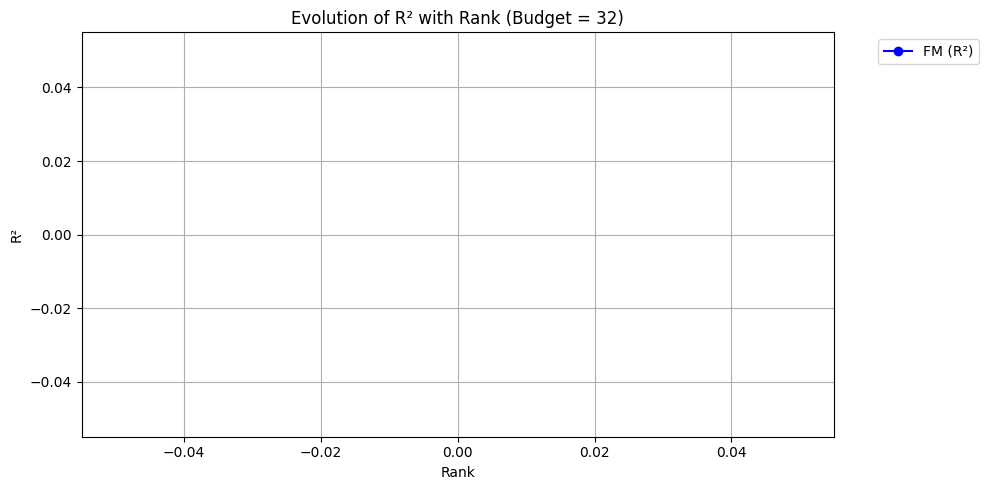

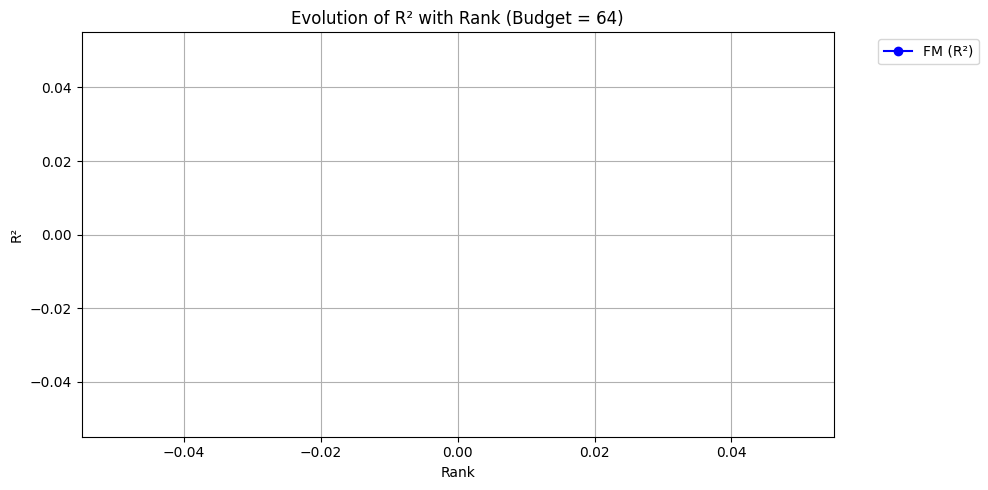

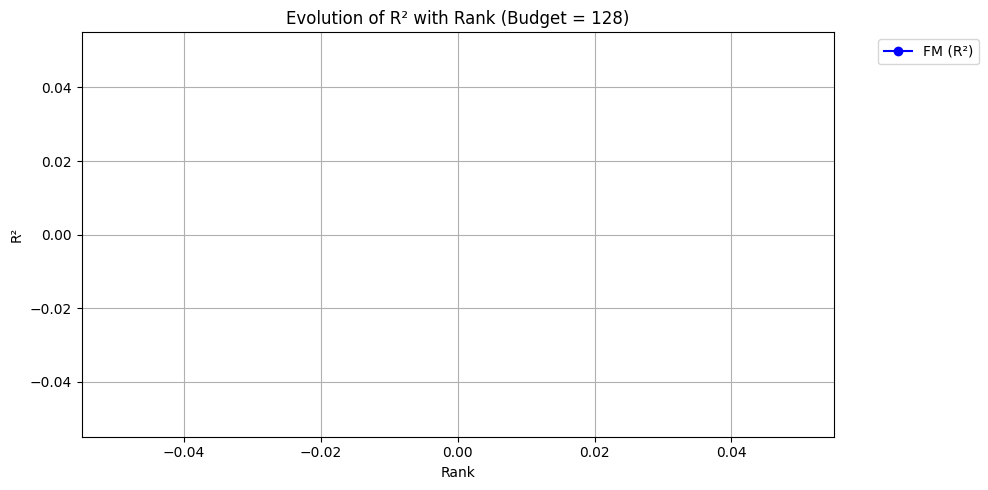

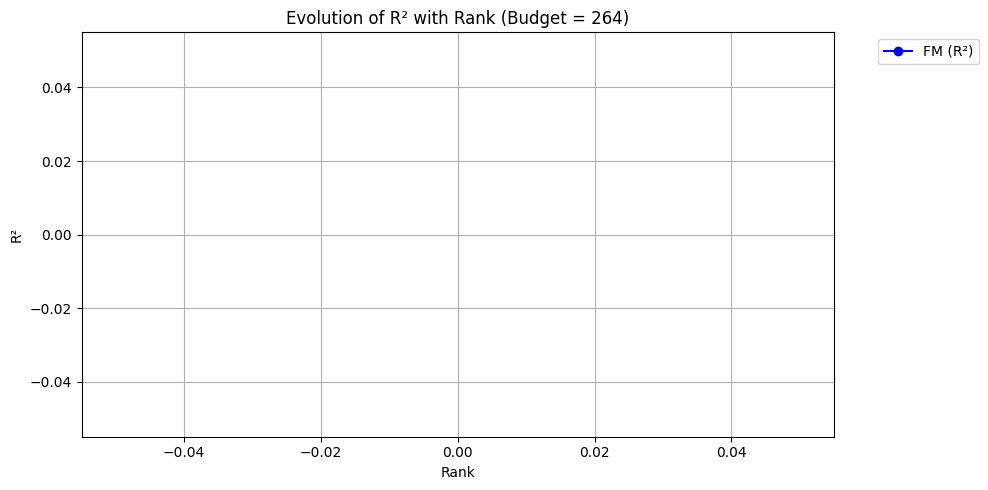

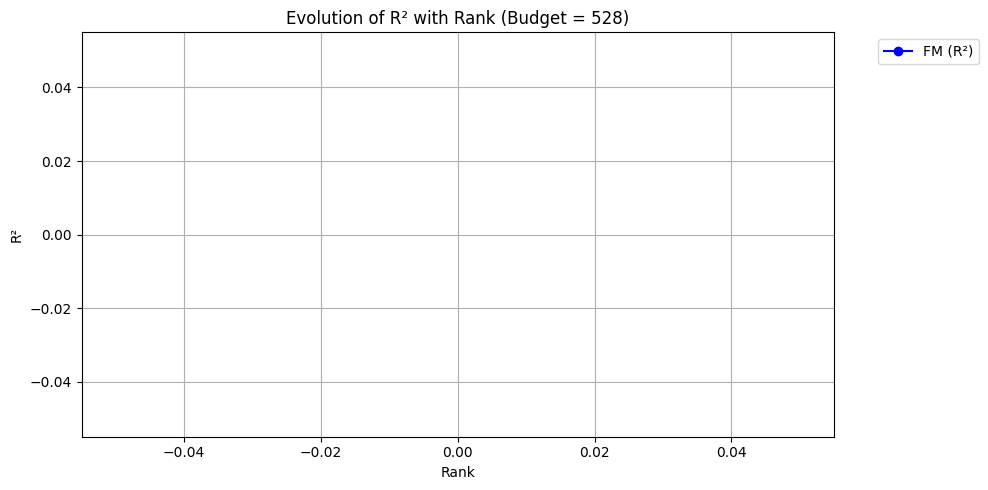

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Reset index
df_reset = df_res.reset_index().rename(columns={'index': 'method'})

# Parse FM methods (rank + budget)
def parse_fm(method):
    parts = method.split("_")
    if parts[0] == "FM" and "WeightsLU" in parts[1]:
        rank = int(parts[2])
        budget = int(parts[-1])
        return rank, budget
    return None, None

df_reset['rank'], df_reset['budget'] = zip(*df_reset['method'].apply(parse_fm))

# Separate FM and non-FM methods
df_fm = df_reset[df_reset['rank'].notnull()]
df_nonfm = df_reset[df_reset['rank'].isnull()]

# Keep only ContextCite baselines
df_contextcite = df_nonfm[df_nonfm['method'].str.startswith("ContextCite")]

# Function to plot R² for a given budget
def plot_r2_for_budget(budget):
    plt.figure(figsize=(10, 5))

    # Subset FM methods for this budget
    subset_fm = df_fm[df_fm['budget'] == budget].sort_values(by='rank')

    # Plot FM evolution (R² vs rank)
    plt.plot(subset_fm['rank'], subset_fm['R2'], marker='o', color="blue", label="FM (R²)")

    # Plot only ContextCite baselines for this budget
    for _, row in df_contextcite.iterrows():
        if row['method'].endswith(f"_{budget}"):
            plt.axhline(y=row['R2'], linestyle='--', color="black", alpha=0.7, label=row['method'])

    plt.xlabel("Rank")
    plt.ylabel("R²")
    plt.title(f"Evolution of R² with Rank (Budget = {budget})")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example: plot for budget = 528
plot_r2_for_budget(32)
plot_r2_for_budget(64)
plot_r2_for_budget(128)
plot_r2_for_budget(264)
plot_r2_for_budget(528)

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Reset index
df_reset = df_res.reset_index().rename(columns={'index': 'method'})

# Parse FM methods (rank + budget)
def parse_fm(method):
    parts = method.split("_")
    if parts[0] == "FM" and "WeightsLU" in parts[1]:
        rank = int(parts[2])
        budget = int(parts[-1])
        return rank, budget
    return None, None

df_reset['rank'], df_reset['budget'] = zip(*df_reset['method'].apply(parse_fm))

# Separate FM and non-FM methods
df_fm = df_reset[df_reset['rank'].notnull()]
df_nonfm = df_reset[df_reset['rank'].isnull()]

# Keep only ContextCite baselines
df_contextcite = df_nonfm[df_nonfm['method'].str.startswith("ContextCite")]

# Function to plot R² for a given budget
def plot_r2_for_budget(budget):
    plt.figure(figsize=(10, 5))

    # Subset FM methods for this budget
    subset_fm = df_fm[df_fm['budget'] == budget].sort_values(by='rank')

    # Plot FM evolution (R² vs rank)
    plt.plot(subset_fm['rank'], subset_fm['LDS'], marker='o', color="blue", label="FM (LDS)")

    # Plot only ContextCite baselines for this budget
    for _, row in df_contextcite.iterrows():
        if row['method'].endswith(f"_{budget}"):
            plt.axhline(y=row['LDS'], linestyle='--', color="black", alpha=0.7, label=row['method'])

    plt.xlabel("Rank")
    plt.ylabel("LDS")
    plt.title(f"Evolution of LDS with Rank (Budget = {budget})")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example: plot for budget = 528
plot_r2_for_budget(32)
plot_r2_for_budget(64)
plot_r2_for_budget(128)
plot_r2_for_budget(264)
plot_r2_for_budget(528)

KeyError: 'LDS'

<Figure size 1000x500 with 0 Axes>

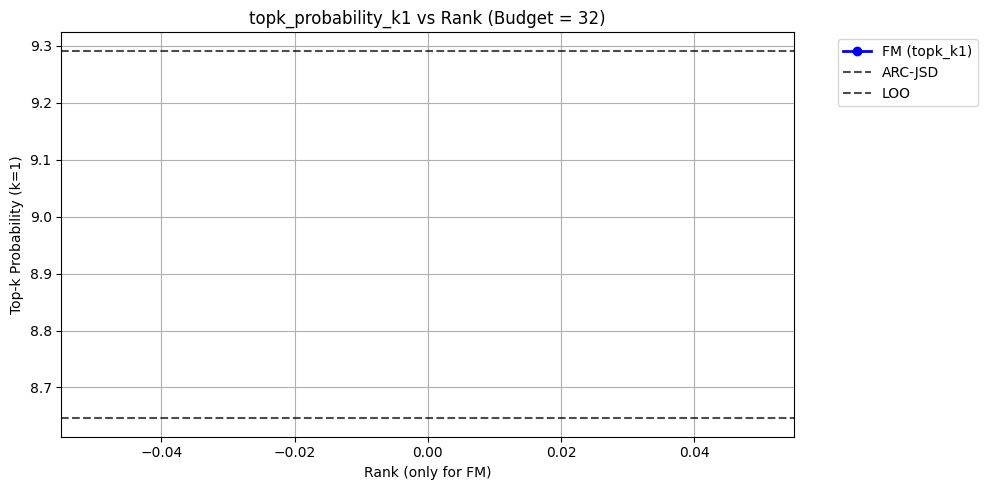

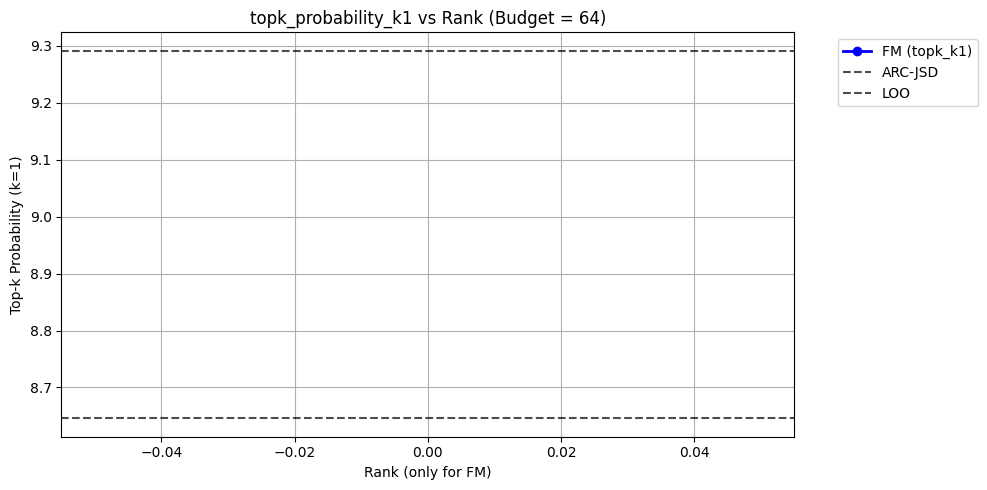

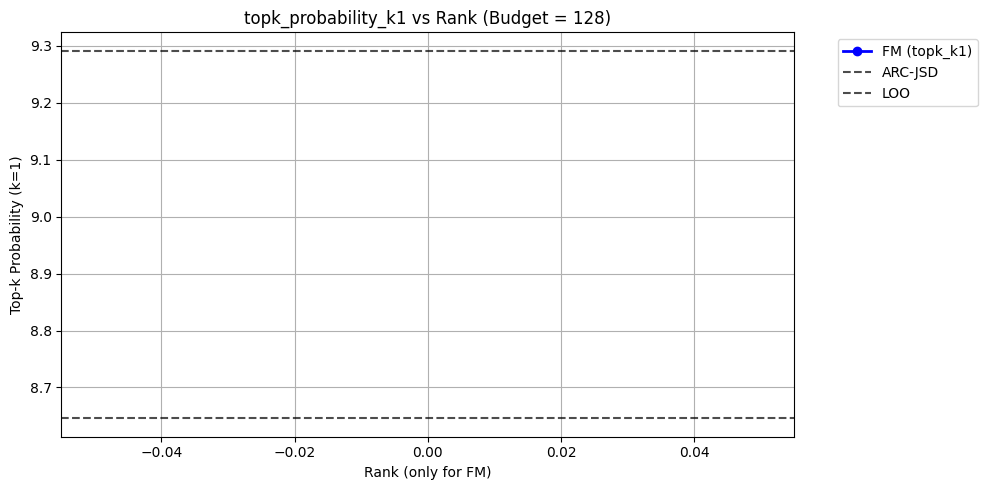

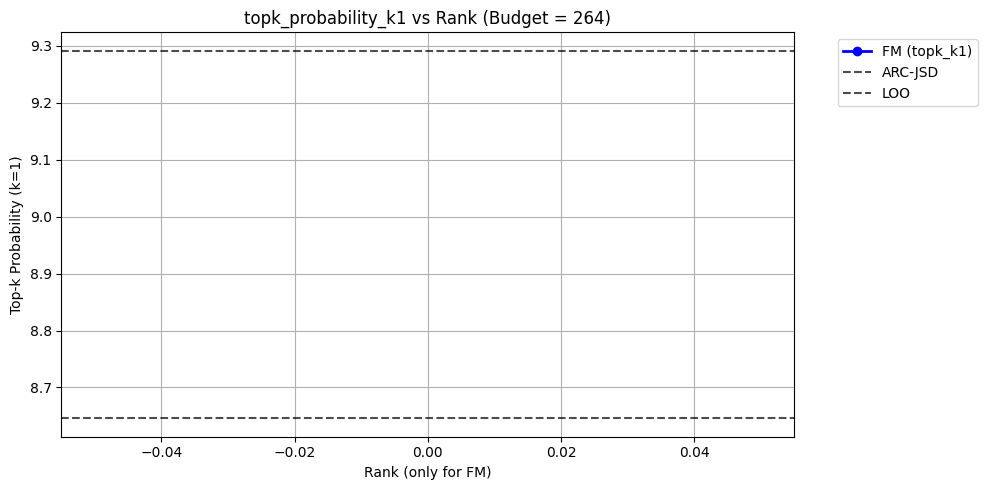

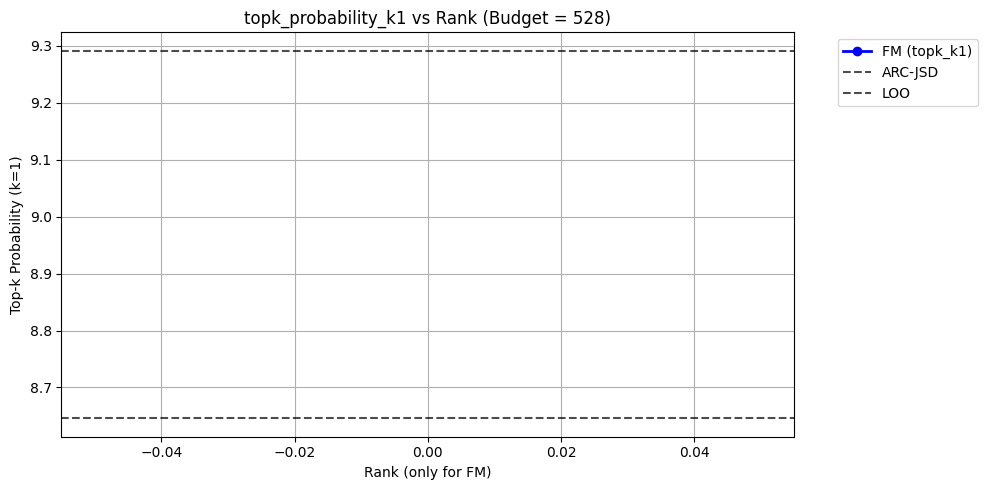

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Reset index
df_reset = df_res.reset_index().rename(columns={'index': 'method'})

# Parse FM methods (rank + budget)
def parse_fm(method):
    parts = method.split("_")
    if parts[0] == "FM" and "WeightsLU" in parts[1]:
        rank = int(parts[2])
        budget = int(parts[-1])
        return rank, budget
    return None, None

df_reset['rank'], df_reset['budget'] = zip(*df_reset['method'].apply(parse_fm))

# Separate FM and non-FM methods
df_fm = df_reset[df_reset['rank'].notnull()]
df_nonfm = df_reset[df_reset['rank'].isnull()]

# Function to plot topk_probability_k1 for a given budget
def plot_topk_for_budget(budget):
    plt.figure(figsize=(10, 5))

    # Subset FM methods for this budget
    subset_fm = df_fm[df_fm['budget'] == budget].sort_values(by='rank')

    # Plot FM evolution (vs rank)
    plt.plot(subset_fm['rank'], subset_fm['topk_probability_k1'],
             marker='o', color="blue", linewidth=2, label="FM (topk_k1)")

    # Plot all other methods as black dashed lines
    for _, row in df_nonfm.iterrows():
        if row['method'].endswith(f"_{budget}") or row['method'] in ["LOO", "ARC-JSD"]:
            plt.axhline(y=row['topk_probability_k1'],
                        linestyle='--', color="black", alpha=0.7, label=row['method'])

    plt.xlabel("Rank (only for FM)")
    plt.ylabel("Top-k Probability (k=1)")
    plt.title(f"topk_probability_k1 vs Rank (Budget = {budget})")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example: plot for budget = 528
plot_topk_for_budget(32)
plot_topk_for_budget(64)
plot_topk_for_budget(128)
plot_topk_for_budget(264)
plot_topk_for_budget(528)


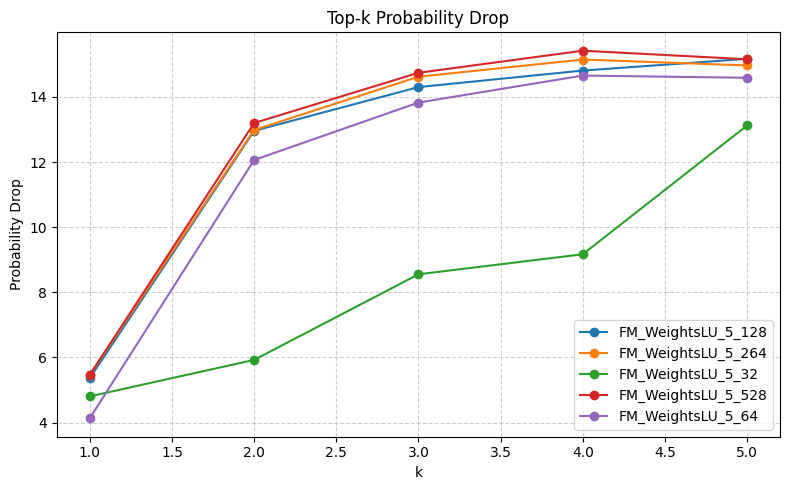

In [11]:
plt.figure(figsize=(8, 5))
for method in df_res.index:
    if "FM_WeightsLU_5" in method:
        plt.plot(
            [1, 2, 3,4,5],
            df_res.loc[method, ['topk_probability_k1', 'topk_probability_k2', 'topk_probability_k3', 'topk_probability_k4', 'topk_probability_k5']],
            marker='o',
            label=method
        )

plt.xlabel('k')
plt.ylabel('Probability Drop')
plt.title('Top-k Probability Drop')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Second stage

In [12]:
import numpy as np

def evaluate_methods(extras, k, m, interaction_type="max"):

    methods = extras[1].keys()
    scores = {m: 0 for m in methods}
    n_experiments = len(extras)

    for exp in extras:
        for method in methods:
            if "Flu"in method:
                # Flu is a matrix
                value = exp[method][k][m]
                all_values = exp[method].flatten()
            else:
                # Dictionaries with tuple keys
                d = exp[method]
                value = None
                for key, v in d.items():
                    ones = [i for i, bit in enumerate(key) if bit == 1]
                    if set(ones) == {k, m}:
                        value = v
                        break
                if value is None:
                    continue  # skip if (k,m) not found
                all_values = list(d.values())

            if interaction_type == "max":
                if value == max(all_values):
                    scores[method] += 1
            elif interaction_type == "min":
                if value == min(all_values):
                    scores[method] += 1

    # Convert to fraction of experiments
    results = {method: scores[method] / n_experiments for method in methods}
    return results

In [15]:
# Recovery rate
rr={}
for i, j in enumerate(np.array(list(evaluate_methods(extras, k=0, m=1, interaction_type="max").values()))+np.array(list(evaluate_methods(extras, k=0, m=5, interaction_type="max").values()))+np.array(list(evaluate_methods(extras, k=5, m=1, interaction_type="min").values()))):
    rr.update({list(extras[1].keys())[i]:j})

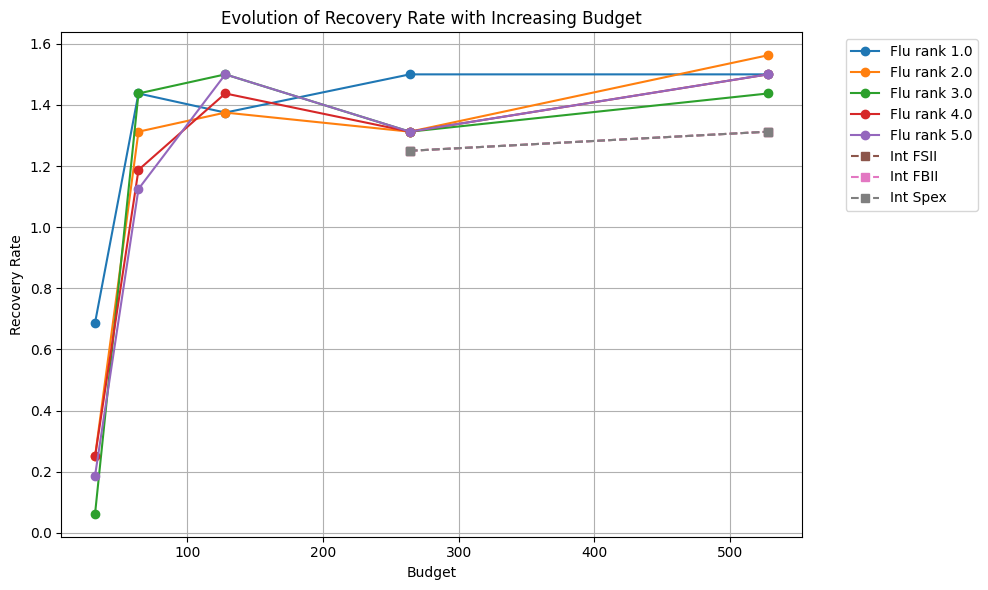

In [21]:
rows = []
for k, v in rr.items():
    parts = k.split("_")
    if parts[0] == "Flu" and parts[1]!='0':
        _, rank, budget = parts
        rows.append({"method": "Flu", "rank": int(rank), "budget": int(budget), "recovery": v})
    elif parts[0] == "Int":
        _, name, budget = parts
        rows.append({"method": name, "rank": None, "budget": int(budget), "recovery": v})

df = pd.DataFrame(rows)

# Plot
plt.figure(figsize=(10, 6))

# Plot Flu (different ranks as lines)
for rank in sorted(df[df["method"]=="Flu"]["rank"].unique()):
    sub = df[(df["method"]=="Flu") & (df["rank"]==rank)].sort_values("budget")
    plt.plot(sub["budget"], sub["recovery"], marker="o", label=f"Flu rank {rank}")

# Plot Int methods (evolve with budget, start at 264)
for m in df[df["method"].isin(["FSII","FBII","Spex"])]['method'].unique():
    sub = df[df["method"]==m].sort_values("budget")
    plt.plot(sub["budget"], sub["recovery"], marker="s", linestyle="--", label=f"Int {m}")

plt.xlabel("Budget")
plt.ylabel("Recovery Rate")
plt.title("Evolution of Recovery Rate with Increasing Budget")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()